# Amazon Reviews Sentiment Analysis

## Imports

In [4]:
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, auc
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
import shap

# PySpark
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when, lower, regexp_replace, concat_ws

# HuggingFace
from datasets import Dataset
from transformers import DistilBertTokenizerFast, AutoModelForSequenceClassification, pipeline

# PyTorch
import torch
from torch.utils.data import DataLoader
from torch.optim import AdamW
from torch.nn import CrossEntropyLoss
import torch.nn.functional as F

## PySpark Setup

In [6]:
# Create SparkSession
spark = (
    SparkSession.builder
        .appName("AmazonReviewSentimentAnalysis")
        .master('local[4]') # run locally using 4 cores
        .getOrCreate()
)

In [7]:
# Check number of cores being used
sc = spark.sparkContext
print(f"Number of cores: {sc.defaultParallelism}")

Number of cores: 4


## Data Preprocessing

In [9]:
# Load train and test sets
train_df = spark.read.csv('../data/train.csv')
test_df = spark.read.csv('../data/test.csv')

# Preview datasets
train_df.show(5)
test_df.show(5)

+---+--------------------+--------------------+
|_c0|                 _c1|                 _c2|
+---+--------------------+--------------------+
|  2|Stuning even for ...|This sound track ...|
|  2|The best soundtra...|I'm reading a lot...|
|  2|            Amazing!|"This soundtrack ...|
|  2|Excellent Soundtrack|I truly like this...|
|  2|Remember, Pull Yo...|If you've played ...|
+---+--------------------+--------------------+
only showing top 5 rows

+---+--------------------+--------------------+
|_c0|                 _c1|                 _c2|
+---+--------------------+--------------------+
|  2|            Great CD|"My lovely Pat ha...|
|  2|One of the best g...|Despite the fact ...|
|  1|Batteries died wi...|I bought this cha...|
|  2|works fine, but M...|Check out Maha En...|
|  2|Great for the non...|Reviewed quite a ...|
+---+--------------------+--------------------+
only showing top 5 rows



In [10]:
# Check column dtypes
train_df.printSchema()
test_df.printSchema()

root
 |-- _c0: string (nullable = true)
 |-- _c1: string (nullable = true)
 |-- _c2: string (nullable = true)

root
 |-- _c0: string (nullable = true)
 |-- _c1: string (nullable = true)
 |-- _c2: string (nullable = true)



In [11]:
# Add proper column headers
train_df = train_df.withColumnRenamed('_c0', 'sentiment')
train_df = train_df.withColumnRenamed('_c1', 'review_title')
train_df = train_df.withColumnRenamed('_c2', 'review_text')

test_df = test_df.withColumnRenamed('_c0', 'sentiment')
test_df = test_df.withColumnRenamed('_c1', 'review_title')
test_df = test_df.withColumnRenamed('_c2', 'review_text')

print(train_df.columns)
print(test_df.columns)


# Check missing
print(train_df.filter(col('sentiment').isNull()).count())
print(test_df.filter(col('sentiment').isNull()).count())


# Convert label values from 1 = negative, 2 = positive to 0 = negative, 1 = positive
train_df = train_df.withColumn('sentiment', when(col('sentiment') == '2', 1).otherwise(0))
test_df = test_df.withColumn('sentiment', when(col('sentiment') == '2', 1).otherwise(0))

train_df.groupBy('sentiment').count().show()
test_df.groupBy('sentiment').count().show()


# Combine review title and review text into single text column
train_df = train_df.withColumn('full_text', concat_ws(',', col('review_title'), col('review_text')))
test_df = test_df.withColumn('full_text', concat_ws(',', col('review_title'), col('review_text')))

train_df.show(5)
test_df.show(5)

['sentiment', 'review_title', 'review_text']
['sentiment', 'review_title', 'review_text']
0
0
+---------+-------+
|sentiment|  count|
+---------+-------+
|        1|1800000|
|        0|1800000|
+---------+-------+

+---------+------+
|sentiment| count|
+---------+------+
|        1|200000|
|        0|200000|
+---------+------+

+---------+--------------------+--------------------+--------------------+
|sentiment|        review_title|         review_text|           full_text|
+---------+--------------------+--------------------+--------------------+
|        1|Stuning even for ...|This sound track ...|Stuning even for ...|
|        1|The best soundtra...|I'm reading a lot...|The best soundtra...|
|        1|            Amazing!|"This soundtrack ...|Amazing!,"This so...|
|        1|Excellent Soundtrack|I truly like this...|Excellent Soundtr...|
|        1|Remember, Pull Yo...|If you've played ...|Remember, Pull Yo...|
+---------+--------------------+--------------------+-----------------

In [12]:
# Sample 5% of total rows from train and test sets for fine-tuning
train_sample = train_df.sample(fraction=0.05, seed=42)
test_sample = test_df.sample(fraction=0.05, seed=42)

print(f'Train sample: {train_sample.count()}')
print(f"Test sample count: {test_sample.count()}")


# Only keep full text and sentiment columns
train_sample = train_sample.select('full_text', 'sentiment')
test_sample = test_sample.select("full_text", "sentiment")

print(train_sample.columns)
print(test_sample.columns)

# Convert samples to pandas df
train_sample_pd = train_sample.toPandas()
test_sample_pd = test_sample.toPandas()

print(train_sample_pd.head(5))
print(test_sample_pd.head(5))

Train sample: 179580
Test sample count: 20052
['full_text', 'sentiment']
['full_text', 'sentiment']
                                           full_text  sentiment
0  A romantic zen baseball comedy,"When you hear ...          1
1  Creepy,Wow, what people will do behind jealous...          1
2  No instructions included - do not trust seller...          0
3  Too Uncomfortable and Too Big,These pants were...          0
4  You need a good memory,I play this with my gra...          1
                                           full_text  sentiment
0  Simple, Durable, Fun game for all ages,This is...          1
1  1, and thats being generous....,"I have read m...          0
2  Painful,"This book has to be one of the most t...          0
3  one of the worst movies of 2002,god!!! what a ...          0
4  Not the worst, but far from good,"This film ha...          0


## Tokenization + Hugging Face Dataset

In [14]:
# Create Hugging Face dataset
train_texts = train_sample_pd['full_text'].tolist()
train_labels = train_sample_pd['sentiment'].tolist()

test_texts = test_sample_pd['full_text'].tolist()
test_labels = test_sample_pd['sentiment'].tolist()

train_dataset = Dataset.from_dict({
    'text': train_texts,
    'label': train_labels
})

test_dataset = Dataset.from_dict({
    'text': test_texts,
    'label': test_labels
})

In [15]:
# Initialize tokenizer
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

def tokenize_function(x):
    return tokenizer(
        x['text'],
        truncation=True,
        padding='max_length',
        max_length=128
    )

train_dataset = train_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/179580 [00:00<?, ? examples/s]

Map:   0%|          | 0/20052 [00:00<?, ? examples/s]

In [16]:
# Get lengths of each tokenized sequence without truncation
train_lengths = [len(tokenizer.encode(text, add_special_tokens=True)) for text in train_sample_pd['full_text']]
test_lengths  = [len(tokenizer.encode(text, add_special_tokens=True)) for text in test_sample_pd['full_text']]

# Check how many have more than 128 tokens
train_cut = np.sum(np.array(train_lengths) > 128)
test_cut  = np.sum(np.array(test_lengths) > 128)

print(f"Train rows longer than 128 tokens: {train_cut}/{len(train_lengths)}")
print(f"Test rows longer than 128 tokens: {test_cut}/{len(test_lengths)}")

Train rows longer than 128 tokens: 41593/179580
Test rows longer than 128 tokens: 4638/20052


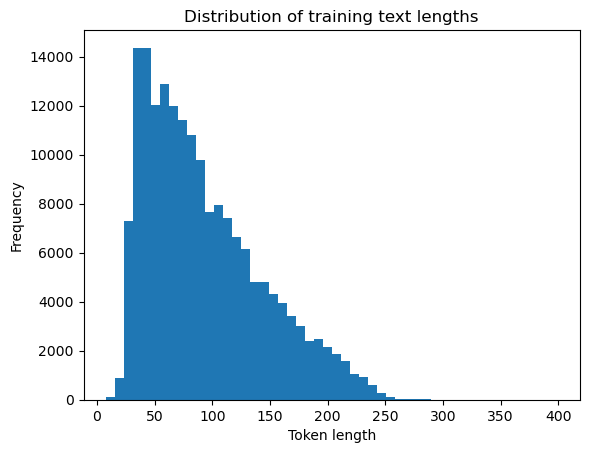

In [17]:
# Plot distribution of training token lengths
plt.hist(train_lengths, bins=50)
plt.xlabel("Token length")
plt.ylabel("Frequency")
plt.title("Distribution of training text lengths")
plt.show()

## Model Training

In [19]:
# Convert data to tensors
train_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
test_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

In [20]:
# Check if CUDA is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Using device: {device}") 

Using device: cuda


In [21]:
# Initialize model
num_labels = len(set(train_labels))
model = AutoModelForSequenceClassification.from_pretrained(
    'distilbert-base-uncased',
    num_labels=num_labels
)

# Move model to GPU
model.to(device)

# Define optimizer
optimizer = AdamW(model.parameters(), lr=5e-5)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [22]:
num_epochs = 1  # number of passes through the dataset

for epoch in range(num_epochs):
    model.train()  # training mode
    
    loop = tqdm(train_loader, leave=True)  # wrap DataLoader with tqdm for progress tracking
    
    for batch in loop:
        optimizer.zero_grad()
        
        # move batch to device
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)
        
        # forward pass
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        
        # backward + update
        loss.backward()
        optimizer.step()
        
        # update progress bar
        loop.set_description(f"Epoch {epoch+1}")
        loop.set_postfix(loss=loss.item())

Epoch 1: 100%|██████████| 5612/5612 [22:31<00:00,  4.15it/s, loss=0.218]  


## Model Evaluation

In [24]:
model.eval()  # disables dropout & other training-only layers

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


In [25]:
all_preds = []
all_labels = []
all_probs = []

# Wrap the test_loader with tqdm for a progress bar
loop = tqdm(test_loader, leave=True, desc="Evaluating")

with torch.no_grad():  # prevent gradient computation
    for batch in loop:
        # move batch to device
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        # forward pass
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits

        # convert logits to probabilities
        probs = F.softmax(logits, dim=1)  # softmax along classes

        # get predicted class
        preds = torch.argmax(probs, dim=1)

        # store results for metric computation
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

Evaluating: 100%|██████████| 627/627 [00:46<00:00, 13.59it/s]


In [26]:
# Classification report
print("Classification Report:")
print(classification_report(all_labels, all_preds))

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.94      0.95      9974
           1       0.95      0.95      0.95     10078

    accuracy                           0.95     20052
   macro avg       0.95      0.95      0.95     20052
weighted avg       0.95      0.95      0.95     20052



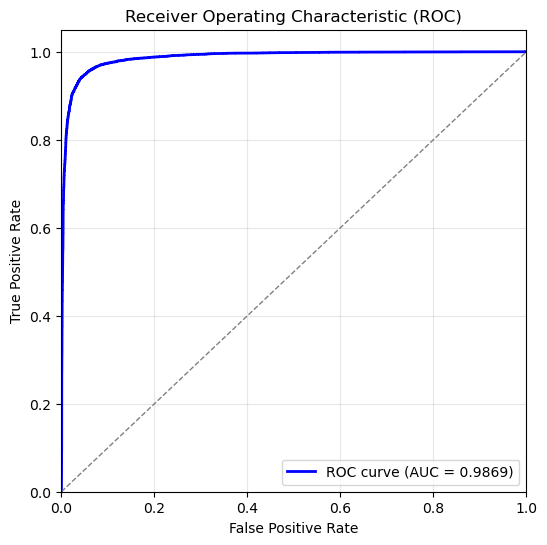

In [27]:
# all_probs should be shape (num_samples, 2) for binary classification
# get the probability of the positive class (usually class 1)
pos_probs = np.array(all_probs)[:, 1]

# compute false positive rate (fpr), true positive rate (tpr), thresholds
fpr, tpr, thresholds = roc_curve(all_labels, pos_probs)

# compute AUC
roc_auc = auc(fpr, tpr)

# plot the ROC curve
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')  # random guess line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

## Baseline Logistic Regression Model

In [29]:
# 1. Convert text to TF-IDF features
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf_vectorizer.fit_transform(train_texts)
X_test_tfidf  = tfidf_vectorizer.transform(test_texts)

# 2. Train logistic regression
lr_clf = LogisticRegression(max_iter=1000)
lr_clf.fit(X_train_tfidf, train_labels)

# 3. Predict
y_pred_lr  = lr_clf.predict(X_test_tfidf)
y_probs_lr = lr_clf.predict_proba(X_test_tfidf)[:, 1]  # probability for positive clas

# 4. Evaluation
print("Classification Report (Logistic Regression):")
print(classification_report(test_labels, y_pred_lr))

roc_auc_lr = roc_auc_score(test_labels, y_probs_lr)
print(f"ROC-AUC (Logistic Regression): {roc_auc_lr:.4f}")

Classification Report (Logistic Regression):
              precision    recall  f1-score   support

           0       0.89      0.89      0.89      9974
           1       0.89      0.89      0.89     10078

    accuracy                           0.89     20052
   macro avg       0.89      0.89      0.89     20052
weighted avg       0.89      0.89      0.89     20052

ROC-AUC (Logistic Regression): 0.9551


## Model Interpretability (SHAP)

In [31]:
# Ensure model is in evaluation mode
model.eval()

# Wrapper function for SHAP
def predict_proba_shap(tokenized_texts):
    """
    tokenized_texts: List[List[str]]  -> SHAP passes pre-tokenized words
    returns: np.array of shape (n_samples, n_classes)
    """
    # Re-join tokens into strings
    texts = [" ".join(tokens) for tokens in tokenized_texts]

    # Tokenize for model
    encodings = tokenizer(
        texts,
        truncation=True,
        padding=True,
        max_length=128,
        return_tensors="pt"
    ).to(device)

    with torch.no_grad():
        outputs = model(**encodings)
        probs = F.softmax(outputs.logits, dim=1)

    return probs.cpu().numpy()

In [32]:
# Take a small subset of training data as background
background_texts = train_texts[:100]

# Text masker
masker = shap.maskers.Text(tokenizer)

# Explainer
explainer = shap.Explainer(predict_proba_shap, masker=masker)

In [33]:
# SHAP expects a list of strings (or list of token lists)
example_review = [test_texts[0]]  # single review in a list

# Compute SHAP values
shap_values = explainer(example_review)

# Visualize
shap.plots.text(shap_values[0])

PartitionExplainer explainer: 2it [00:20, 20.10s/it]               


## Negative Reviews Classification

In [35]:
# Filter negative reviews
negative_reviews = [review for review, pred in zip(test_texts, all_preds) if pred == 0]

print(f"Number of negative reviews: {len(negative_reviews)}")

Number of negative reviews: 9893


In [36]:
# Initialize classifier
classifier = pipeline("zero-shot-classification", model="facebook/bart-large-mnli")

# Predefined labels
candidate_labels = ["Delivery issue", "Product quality", "Customer service", "Price", "Other"]

Device set to use cuda:0


In [37]:
categorized_negatives = []

for review in tqdm(negative_reviews, desc="Classifying negative reviews"):
    result = classifier(review, candidate_labels)
    categorized_negatives.append({
        "review": review,
        "predicted_category": result['labels'][0],
        "confidence": result['scores'][0]
    })

# Convert to DataFrame
df_negatives = pd.DataFrame(categorized_negatives)
print(df_negatives.head())

Classifying negative reviews: 100%|██████████| 9893/9893 [31:41<00:00,  5.20it/s]

                                              review predicted_category  \
0  1, and thats being generous....,"I have read m...    Product quality   
1  Painful,"This book has to be one of the most t...              Other   
2  one of the worst movies of 2002,god!!! what a ...              Other   
3  Not the worst, but far from good,"This film ha...    Product quality   
4  Lacking,The movie was fine to watch but it was...              Other   

   confidence  
0    0.369382  
1    0.383679  
2    0.340964  
3    0.373708  
4    0.648127  


In [65]:
df_negatives['predicted_category'].value_counts()

predicted_category
Product quality     4659
Other               3163
Delivery issue      1468
Price                390
Customer service     213
Name: count, dtype: int64

In [77]:
# Count total rows
total_rows = len(df_negatives)

# Count rows with "Product quality"
product_quality_rows = len(df_negatives[df_negatives['predicted_category'] == 'Product quality'])

# Compute percentage
percentage = (product_quality_rows / total_rows) * 100

print(f"{percentage:.2f}%")

47.09%
